# Ismerkedjünk meg az SVD-vel

## Nézzük meg, hogy lehet-e csökkenteni a dimenziószámot

In [1]:
import numpy as np
A = np.array([[1, 3, 4], [2, 3, 5], [1, 2, 3], [5, 4, 6]])
print(A)

[[1 3 4]
 [2 3 5]
 [1 2 3]
 [5 4 6]]


In [2]:
U, s, Vh = np.linalg.svd(A, full_matrices=False)
print(np.shape(U), np.shape(s), np.shape(Vh))
print(s)

(4, 3) (3,) (3, 3)
[12.26362747  2.11085464  0.38436189]


In [3]:
print(np.dot(np.dot(U, np.diag(s)), Vh)) # A mátrix teljes helyreállítása

[[1. 3. 4.]
 [2. 3. 5.]
 [1. 2. 3.]
 [5. 4. 6.]]


In [4]:
print(np.round(np.dot(np.dot(U[:,:2], np.diag(s[:2])),
                      Vh[:2,:]),1)) # k=2 helyreállítás

[[1.  2.8 4.1]
 [2.  3.2 4.8]
 [1.  2.  3. ]
 [5.  3.9 6. ]]


In [5]:
print(np.round(np.dot(np.dot(U[:,:1], np.diag(s[:1])),
                      Vh[:1,:]),1)) # k=1 helyreállítás

[[2.1 2.5 3.7]
 [2.6 3.1 4.6]
 [1.6 1.8 2.8]
 [3.7 4.3 6.5]]


# Végezzünk faktoranalízist és főkomponens-analízist

## Keressünk rejtett faktorokat

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def palmer_pingvinek_betöltése():
    url = "https://raw.githubusercontent.com/allisonhorst/" \
"palmerpenguins/main/inst/extdata/penguins.csv"
    numerikus_jellemzők = ["bill_length_mm", "bill_depth_mm",                          "flipper_length_mm", "body_mass_g"]
    adatok = pd.read_csv(url).dropna()
    cél = adatok.species.replace({'Adelie':1, 'Gentoo':2,                                    'Chinstrap':3})
    adatok[numerikus_jellemzők] = StandardScaler()  \
.fit_transform(adatok[numerikus_jellemzők])
    return adatok[numerikus_jellemzők], cél

X, y = palmer_pingvinek_betöltése()


In [7]:
from sklearn.decomposition import FactorAnalysis
faktor = FactorAnalysis(n_components=4).fit(X)

In [8]:
print(pd.DataFrame(faktor.components_, columns=X.columns).T)

                          0         1    2    3
bill_length_mm     0.665834  0.179744 -0.0  0.0
bill_depth_mm     -0.561658  0.236985  0.0 -0.0
flipper_length_mm  0.874881 -0.009841  0.0 -0.0
body_mass_g        0.840450  0.010157  0.0  0.0


## Érjük el a dimenziószám csökkentését

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components="mle").fit(X)
print('Az egyes komponensek magyarázott szórása:',
      pca.explained_variance_ratio_.round(5),"\n")
print(pd.DataFrame(pca.components_, columns=X.columns).T)

Az egyes komponensek magyarázott szórása: [0.68634 0.19453 0.09216] 

                          0         1         2
bill_length_mm     0.453753  0.600195  0.642495
bill_depth_mm     -0.399047  0.796170 -0.425800
flipper_length_mm  0.576825  0.005788 -0.236095
body_mass_g        0.549675  0.076464 -0.591737


## Nyomjuk össze az információkat a t-SNE-vel

In [10]:
from sklearn.datasets import load_digits
számjegyek = load_digits()
X = számjegyek.data
y = számjegyek.target

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
            learning_rate="auto",
            init="random",
            random_state=0,
            perplexity=50,
            early_exaggeration=25,
            n_iter=300)

Tx = tsne.fit_transform(X)

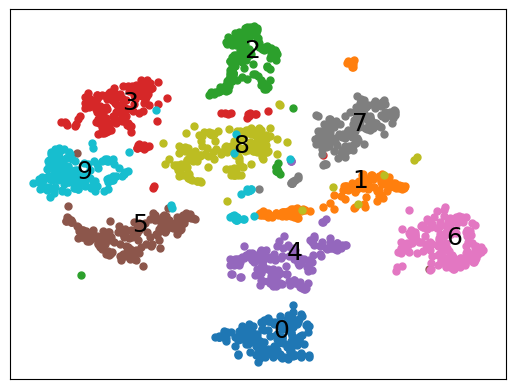

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as dg
dg.xticks([], [])
dg.yticks([], [])
for target in np.unique(y):
    kijelölés = y==target
    X1, X2 = Tx[kijelölés, 0], Tx[kijelölés, 1]
    c1, c2 = np.median(X1), np.median(X2)
    dg.plot(X1, X2, 'o', ms=5)
    dg.text(c1, c2, target, fontsize=18)

# Ismerkedjünk meg néhány alkalmazási területtel

## Ismerjünk fel arcokat a PCA segítségével

In [13]:
from sklearn.datasets import fetch_olivetti_faces
adathalmaz = fetch_olivetti_faces(shuffle=True,
                               random_state=101)
tanító_arcok = adathalmaz.data[:350,:]
teszt_arcok = adathalmaz.data[350:,:]
tanító_válaszok = adathalmaz.target[:350]
teszt_válaszok = adathalmaz.target[350:]

In [14]:
print(adathalmaz.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [15]:
from sklearn.decomposition import PCA
komponensek_száma = 25
Rpca = PCA(svd_solver='randomized',
           n_components=komponensek_száma,
           whiten=True)
Rpca.fit(tanító_arcok)
print(f"A(z) {komponensek_száma}")
print(f"komponens által magyarázott szórás: ",       
      f"{np.sum(Rpca.explained_variance_ratio_):0.3f}")
tömörített_tanító_arcok = Rpca.transform(tanító_arcok)
tömörített_teszt_arcok = Rpca.transform(teszt_arcok)

A(z) 25
komponens által magyarázott szórás:  0.794


Az ábrázolt személy a(z) 34. alany


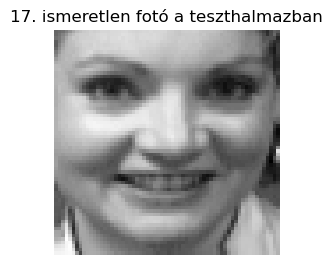

In [16]:
%matplotlib inline
import matplotlib.pyplot as dg

fotó = 17
print(f"Az ábrázolt személy a(z) "
       f"{teszt_válaszok[fotó]}"
       f". alany")
dg.subplot(1, 2, 1)
dg.axis('off')
dg.title(f"{fotó}. ismeretlen fotó a teszthalmazban")
dg.imshow(teszt_arcok[fotó].reshape(64, 64),
           cmap=dg.cm.gray, interpolation="nearest")
dg.show()

In [17]:
maszk = tömörített_teszt_arcok[fotó,]
négyzetes_hibák = np.sum((tömörített_tanító_arcok
                         - maszk)**2, axis=1)
minimális_hibájú_arc = np.argmin(négyzetes_hibák)
leginkább_hasonló = list(np.where(négyzetes_hibák < 20)[0])
print(f"A leginkább hasonló alany a tanító halmazban: "
        f"{tanító_válaszok[minimális_hibájú_arc]}")

A leginkább hasonló alany a tanító halmazban: 34


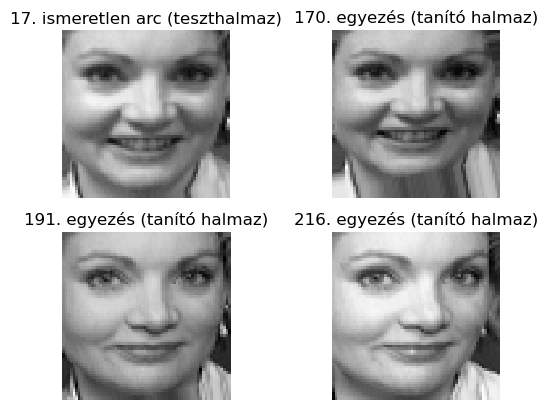

In [18]:
%matplotlib inline
import matplotlib.pyplot as dg
dg.subplot(2, 2, 1)
dg.axis('off')
dg.title(f'{fotó}. ismeretlen arc (teszthalmaz)')
dg.imshow(teszt_arcok[fotó].reshape(64, 64),
           cmap=dg.cm.gray,
           interpolation='nearest')
for k,m in enumerate(leginkább_hasonló[:3]):
    dg.subplot(2, 2, 2+k)
    dg.title(f'{m}. egyezés (tanító halmaz)')
    dg.axis('off')
    dg.imshow(tanító_arcok[m].reshape(64, 64),
               cmap=dg.cm.gray,
               interpolation='nearest')
dg.show()

## Nyerjünk ki témákat az NMF használatával

In [19]:
from sklearn.datasets import fetch_20newsgroups
adathalmaz = fetch_20newsgroups(
    shuffle=True,
    categories = ['misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    random_state=101)
print(f'Bejegyzések: {len(adathalmaz.data)}')

Bejegyzések: 585


In [20]:
from sklearn.feature_extraction.text import \
    TfidfVectorizer
from sklearn.decomposition import NMF

vektorizáló = TfidfVectorizer(max_df=0.95, min_df=2,
                             stop_words='english')
tfidf = vektorizáló.fit_transform(adathalmaz.data)

témák_száma = 5
nmf = NMF(n_components=témák_száma,
          init="nndsvda",
          random_state=101).fit(tfidf)

In [21]:
jellemzőnevek = vektorizáló.get_feature_names_out()
n_első_szó = 15
for téma_idx, téma in enumerate(nmf.components_):
    print(f'{téma_idx+1}. téma:', end="\t")
    témák = téma.argsort()[:-n_első_szó - 1:-1]
    print(' '.join([jellemzőnevek[i] for i in témák]))

1. téma:	condition excellent asking offer best car old new sale 10 miles 000 tape cd power
2. téma:	00 50 dos 20 10 15 cover 1st new 25 price man 40 shipping comics
3. téma:	drive hard card floppy monitor meg ram disk motherboard vga modem brand scsi color internal
4. téma:	email looking game games send interested mail thanks like edu good want package price list
5. téma:	shipping vcr works stereo obo included amp plus great volume unc mathes gibbs radley remotes


In [22]:
print(nmf.components_[0,:].argsort()[:-n_első_szó-1:-1])

[1075 1459  632 2463  740  888 2476 2415 2987   10 2305    1 3349  923
 2680]


In [23]:
szóindex = 2463
print(vektorizáló.get_feature_names_out()[szóindex])

offer


## Ajánljunk filmeket

In [24]:
import os
print(os.getcwd())

C:\Users\revon\TKP2024


In [25]:
import urllib.request
import zipfile

def movielens_letöltése():
    url = ("http://files.grouplens.org/datasets"
           "/movielens/ml-1m.zip")
    fájlnév = 'ml-1m.zip'
    urllib.request.urlretrieve(url, fájlnév)
    param = {"sep":"::", "engine":"python",
              "encoding":"latin-1"}

    with zipfile.ZipFile('ml-1m.zip', 'r') as zip_fájl:
        with zip_fájl.open('ml-1m/users.dat') as fájl:
            felhasználók = pd.read_csv(
                fájl,
                names=['user_id', 'gender', 'age',
                       'occupation', 'zip'],
                 **param )
        with zip_fájl.open('ml-1m/ratings.dat') as fájl:
            értékelések = pd.read_csv(
                fájl,
                names=['user_id', 'movie_id', 'rating',
                       'timestamp'],
                 **param)
        with zip_fájl.open('ml-1m/movies.dat') as fájl:
            filmek = pd.read_csv(
                fájl,
                names=['movie_id', 'title', 'genres'],
                 **param)
    return pd.merge(pd.merge(értékelések, felhasználók), filmek)
        
movielens = movielens_letöltése()

In [26]:
értékelések_fcx_ak = movielens.pivot_table(values='rating',
        index='user_id', columns='title', fill_value=0)
film_index = értékelések_fcx_ak.columns

In [27]:
from sklearn.decomposition import TruncatedSVD
ajánl = TruncatedSVD(n_components=15, random_state=101)
R = ajánl.fit_transform(értékelések_fcx_ak.values.T)

In [28]:
film = 'Star Wars: Episode V \
- The Empire Strikes Back (1980)'
film_idx = list(film_index).index(film)
print(f"filmindex: {film_idx}")
print(R[film_idx])

filmindex: 3154
[184.72254552 -17.77612872  47.33450866  51.4664494   47.92058216
  17.65033116  14.3574635  -12.82219207  17.51347857   5.46888807
   7.5430805   -0.57117869 -30.74032355   2.4088565  -22.50368497]


In [29]:
import numpy as np
korrelációs_mátrix = np.corrcoef(R)
P = korrelációs_mátrix[film_idx]
print(list(film_index[(P > 0.95) & (P < 1.0)]))

['Raiders of the Lost Ark (1981)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Terminator, The (1984)']
